# 等离子体波动分析

In [1]:
import numpy as np
from prettytable import PrettyTable
import os
import matplotlib.pyplot as plt
import plasmapy
import scipy.signal
import scipy.optimize as op
%config InlineBackend.figure_format = 'svg'

## 参数设定

In [2]:
k = 0.5
L = 2*np.pi/k
vmax = 5. # 速度最大值
nx = 200
nv = 500
dx = L/(nx-1)
dv = 2*vmax/(nv-1)
x = np.linspace(0, L, num=nx, endpoint=True)
v = np.linspace(-vmax, vmax, num=nv, endpoint=True)
V,X=np.meshgrid(v,x)
max_steps = 20000  # 最大时间步数
data_steps = max_steps
data_num = int(max_steps/data_steps)+1

dt = 0.01
path = 'E:/代码/vlasov-es1d/data/'

# 等离子体参量
q = 1.0
Te = 1  # 温度
me = 1
vt_e = np.sqrt(2*Te/me)
l_e = np.sqrt(Te/q**2)
wp_e = np.sqrt(q**2/me)

Ti = 1.0
mi = 100
vt_i = np.sqrt(2*Ti/mi)
l_i = np.sqrt(Ti/q**2)
wp_i = np.sqrt(q**2/mi)

w_lw = wp_e*(1+1.5*k**2*l_e**2)
w_iaw= wp_i*k*l_e/np.sqrt(1+k**2*l_e**2)
print(w_lw)
print(w_iaw)

1.375
0.044721359549995794


## 色散关系
$$1 +\frac{1}{ k^2 \lambda_e^2 } [1+\zeta_e Z(\zeta_e)]+ \frac{1}{ k^2 \lambda_i^2 } [1+\zeta_i Z(\zeta_i)]=0$$
- 其中$\zeta_{e,i}=\omega/kv_{te,i}$，$v_{te,i}=\sqrt{2kT_{e,i}/m_{e,i}}$

In [3]:
def PDR(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta_e = wc / k /vt_e
    zeta_i = wc / k /vt_i
    re = 1 / k**2 / l_e**2 * ( 1 + zeta_e*plasmapy.dispersion.plasma_dispersion_func(zeta_e) )
    ri = 1 / k**2 / l_i**2 * ( 1 + zeta_i*plasmapy.dispersion.plasma_dispersion_func(zeta_i) )
    r = 1 + re + ri 
    return [r.real,r.imag]
print("k = ",k)
# s=op.root(lambda w:PDR(w,k),[0.031,-0.0188])
s=op.root(lambda w:PDR(w,k),[0.100,-0.0531])
print(s.success)
print("w_r = ",s.x[0])
print("w_i = ",s.x[1])
print("|w_i/w_r| = ",abs(s.x[1]/s.x[0]))

k =  0.5
True
w_r =  0.100242491688018
w_i =  -0.05311508627386971
|w_i/w_r| =  0.5298659817752571


In [5]:
def PDR_LW(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta_e = wc / k /vt_e
    re = 1 / k**2 / l_e**2 * ( 1 + zeta_e*plasmapy.dispersion.plasma_dispersion_func(zeta_e) )
    r = 1 + re
    return [r.real,r.imag]
def PDR_IAW(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta_i = wc / k /vt_i
    r = 1 + Te/Ti*( 1 + zeta_i*plasmapy.dispersion.plasma_dispersion_func(zeta_i) )
    return [r.real,r.imag]
kvec = np.arange(0.1,1.5,0.1)
table = PrettyTable(['k*l_D','w_lw','r_lw','w_iaw','r_iaw','|r/w|_iaw'])
w_iaw_guess = w_iaw
r_iaw_guess = -0.0085
for ki in kvec:
    s_lw=op.root(lambda w:PDR_LW(w,ki),[1,0.1])
#     s_lw=op.root(lambda w:PDR(w,ki),[s_lw_guess.x[0],s_lw_guess.x[1]])
    s_iaw_guess=op.root(lambda w:PDR_IAW(w,ki),[w_iaw_guess,r_iaw_guess])
    s_iaw=op.root(lambda w:PDR(w,ki),[s_iaw_guess.x[0],s_iaw_guess.x[1]])
    kl=round(ki*l_e,6)
    w_lws=round(s_lw.x[0],6)
    r_lws=round(s_lw.x[1],6)
    w_iaws=round(s_iaw.x[0],6)
    r_iaws=round(s_iaw.x[1],6)
    rw_iaw=abs(round(r_iaws/w_iaws,6))
    w_iaw_guess = w_iaws
    r_iaw_guess = r_iaws
    table.add_row([kl,w_lws,r_lws,w_iaws,r_iaws,rw_iaw])
print(table)

+-------+----------+-----------+----------+-----------+-----------+
| k*l_D |   w_lw   |    r_lw   |  w_iaw   |   r_iaw   | |r/w|_iaw |
+-------+----------+-----------+----------+-----------+-----------+
|  0.1  | 1.015198 |    -0.0   | 0.020997 | -0.010109 |  0.48145  |
|  0.2  | 1.063984 |  -5.5e-05 | 0.041726 | -0.020346 |  0.48761  |
|  0.3  | 1.159846 |  -0.01262 | 0.061951 |  -0.03084 |  0.497813 |
|  0.4  | 1.285057 | -0.066128 | 0.081493 | -0.041723 |  0.511983 |
|  0.5  | 1.415662 | -0.153359 | 0.100242 | -0.053115 |  0.529868 |
|  0.6  | 1.545707 |  -0.26411 | 0.118155 |  -0.06512 |  0.55114  |
|  0.7  | 1.673866 | -0.392401 | 0.13524  | -0.077816 |  0.575392 |
|  0.8  | 1.799899 | -0.534552 | 0.151544 | -0.091252 |  0.602149 |
|  0.9  | 1.923865 | -0.688109 | 0.167136 | -0.105449 |  0.630917 |
|  1.0  | 2.045905 |  -0.85133 | 0.182092 | -0.120407 |  0.661243 |
|  1.1  | 2.166175 | -1.022919 | 0.196486 | -0.136109 |  0.692716 |
|  1.2  | 2.284825 | -1.201876 | 0.210391 | -0.1

In [6]:
dataet = np.loadtxt(os.path.join(path,"tot_energy"))[0:max_steps]
dataep = np.loadtxt(os.path.join(path,"pot_energy"))[0:max_steps]
dataek = np.loadtxt(os.path.join(path,"kin_energy"))[0:max_steps]

t = np.linspace(0, max_steps, max_steps)

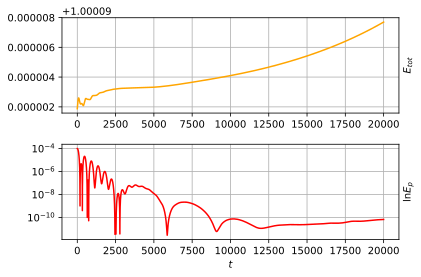

In [7]:
fig = plt.figure(figsize=(6, 4))

ax1 = plt.subplot(211)
ax1.plot(t, dataet, color='orange')
ax1.set_ylabel(r'$E_{tot}$')
ax1.yaxis.set_label_position("right")
ax1.grid()

ax2 = plt.subplot(212)
ax2.plot(t, dataep, color='r')
ax2.set_ylabel(r'$\ln E_p$')
ax2.set_yscale('log')
ax2.yaxis.set_label_position("right")
ax2.grid()

fig.subplots_adjust(bottom=0.1, top=0.9, hspace=.5, wspace=.2)
plt.xlabel(r'$t$')
plt.tight_layout()
plt.show()

In [8]:
progesses = np.arange(0,data_num,1)

fe = []
phi = []
fi = []

for progess in progesses:
    fe_temp = np.loadtxt(os.path.join(path,"fe"+str(progess)))
    fe.append(fe_temp)
    fi_temp = np.loadtxt(os.path.join(path,"fi"+str(progess)))
    fi.append(fi_temp)
    phi_temp = np.loadtxt(os.path.join(path,"phi"+str(progess)))
    phi.append(phi_temp)

In [9]:
fex0 = np.sum(fe[0],axis=1)*dv
fev0 = np.sum(fe[0],axis=0)*dx/L
fex = np.sum(fe[data_num-1],axis=1)*dv
fev = np.sum(fe[data_num-1],axis=0)*dx/L
fix0 = np.sum(fi[0],axis=1)*dv
fiv0 = np.sum(fi[0],axis=0)*dx/L
fix = np.sum(fi[data_num-1],axis=1)*dv
fiv = np.sum(fi[data_num-1],axis=0)*dx/L

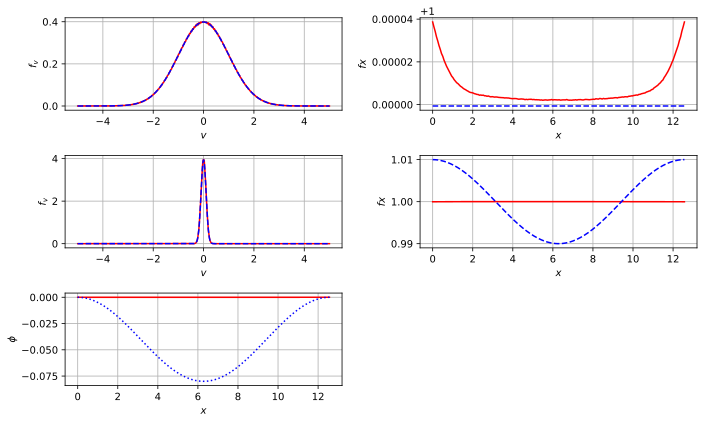

In [10]:
fig = plt.figure(figsize=(10, 6))
xzero = int(nx/2)

ax1 = plt.subplot(321)
ax1.plot(v, fe[data_num-1][xzero,:], color='red')
ax1.plot(v, fe[0][xzero,:],'--', color='blue')
ax1.set_xlabel(r'$v$')
ax1.set_ylabel(r'$f_{v}$')
# ax1.set_yscale('log')
ax1.grid()

ax2 = plt.subplot(322)
ax2.plot(x, fex, color='red')
ax2.plot(x, fex0,'--', color='blue')
ax2.set_xlabel(r'$v$')
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'$fx$')
ax2.grid()

ax3 = plt.subplot(323)
ax3.plot(v, fi[data_num-1][xzero,:], color='red')
ax3.plot(v, fi[0][xzero,:],'--', color='blue')
ax3.set_xlabel(r'$v$')
ax3.set_ylabel(r'$f_{v}$')
# ax3.set_yscale('log')
ax3.grid()

ax4 = plt.subplot(324)
ax4.plot(x, fix, color='red')
ax4.plot(x, fix0,'--', color='blue')
ax4.set_xlabel(r'$v$')
ax4.set_xlabel(r'$x$')
ax4.set_ylabel(r'$fx$')
ax4.grid()

ax5 = plt.subplot(325)
ax5.plot(x, phi[1], color='red')
ax5.plot(x, phi[0],':', color='blue')
# ax5.plot(x, phi_sc,'--', color='black')
ax5.set_xlabel(r'$x$')
ax5.set_ylabel(r'$\phi$')
ax5.grid()

plt.tight_layout()
plt.show()

In [11]:
def line(p, x):
    k, b = p
    return k*x+b


def errorWithLine(p, x, y):
    r = line(p, x)-y
    return r


def period(x):
    return (x[1]-x[0])/1.


def errPercent(a, b):
    r = abs((a-b)/b)
    return r

$$ E_p \propto E^2 \propto \left( e^{i \omega_r t+\omega_i t} \right)^2 = e^{i 2\omega_r t+2\omega_i t} $$

In [12]:
indexes, _ = scipy.signal.find_peaks(dataep[3000:], distance=5)
xep = indexes[3:6:1]
yep = np.log(dataep[xep])
para, nouse = op.leastsq(errorWithLine, [-1, 1], args=(xep, yep))
per_sim = period(xep) * dt
w_r_sim = 2*np.pi/per_sim/2
w_i_sim = para[0]/dt/2
wc_table=PrettyTable(['w_r_theo','w_r_sim','err w_r(%)','w_i_theo','w_i_sim','err w_i(%)'])
wc_array=np.round([s.x[0],w_r_sim,errPercent(w_r_sim,s.x[0])*100,s.x[1],w_i_sim,errPercent(w_i_sim,s.x[1])*100],6)
wc_table.add_row(wc_array)
print(wc_table)

+----------+----------+------------+-----------+-----------+------------+
| w_r_theo | w_r_sim  | err w_r(%) |  w_i_theo |  w_i_sim  | err w_i(%) |
+----------+----------+------------+-----------+-----------+------------+
| 0.100242 | 0.098823 |  1.41576   | -0.053115 | -0.050807 |  4.344596  |
+----------+----------+------------+-----------+-----------+------------+


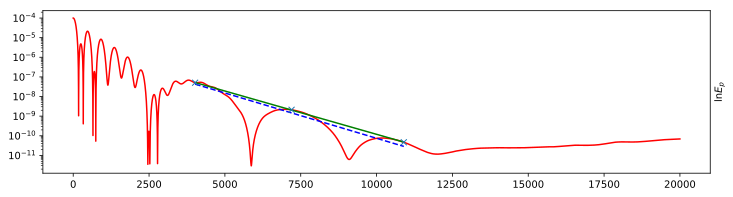

In [13]:
fig = plt.figure(figsize=(12, 3))
ax = plt.gca()
ax.plot(t, dataep, color='r')
ax.plot(xep,np.exp(line(para,xep)), '-',color='green')
ax.plot(xep,np.exp(s.x[1]*xep*dt*2+para[1]), '--',color='blue')

ax.plot(xep,dataep[xep],'x')
ax.set_ylabel(r'$\ln E_p$')
ax.set_yscale('log')
ax.yaxis.set_label_position("right")
plt.show()